# Qualitative QC analysis of counts in each sample
This Python Jupyter notebook performs a qualitative analysis of the counts for the variants in each sample.

## Set up analysis

### Import Python modules.
This notebook primarily makes use of the Bloom lab's [dms_variants](https://jbloomlab.github.io/dms_variants) package, and uses [plotnine](https://github.com/has2k1/plotnine) for ggplot2-like plotting syntax:

In [1]:
import collections
import os
import warnings

import alignparse.targets

import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.plotnine_themes

from IPython.display import display, HTML, Image

import numpy

import pandas as pd

from plotnine import *

import yaml

Set [plotnine](https://github.com/has2k1/plotnine) theme to the gray-grid one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")
print(f"Using alignparse version {alignparse.__version__}")

Using dms_variants version 0.8.9
Using alignparse version 0.2.4


Ignore warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

### Parameters for notebook
Read the configuration file:

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read information about the samples:

In [6]:
sample_info = pd.read_csv(config['barcode_runs'])

Get a list of all the different experiment types 

In [7]:
experiment_types = sample_info['experiment_type'].unique().tolist()

## Initialize codon-variant table
Initialize [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) from wildtype gene sequence and the variant counts CSV file.
We will then use the plotting functions of this variant table to analyze the counts per sample:

In [8]:
# get wildtype gene sequence for primary target
targets = alignparse.targets.Targets(
                seqsfile=config['amplicons'],
                feature_parse_specs=config['feature_parse_specs'])
geneseq = targets.get_target(config['primary_target']).get_feature('gene').seq
print(f"Read gene of {len(geneseq)} nts for {config['primary_target']} from {config['amplicons']}")
      
print('Initializing CodonVariantTable from gene sequence and ' +
      config['variant_counts'])
      
variants = dms_variants.codonvarianttable.CodonVariantTable.from_variant_count_df(
                geneseq=geneseq,
                variant_count_df_file=config['variant_counts'],
                primary_target=config['primary_target'])
      
print('Done initializing CodonVariantTable.')

Read gene of 603 nts for B1351 from data/PacBio_amplicons.gb
Initializing CodonVariantTable from gene sequence and results/counts/variant_counts.csv.gz
Done initializing CodonVariantTable.


## Analyze counts for samples

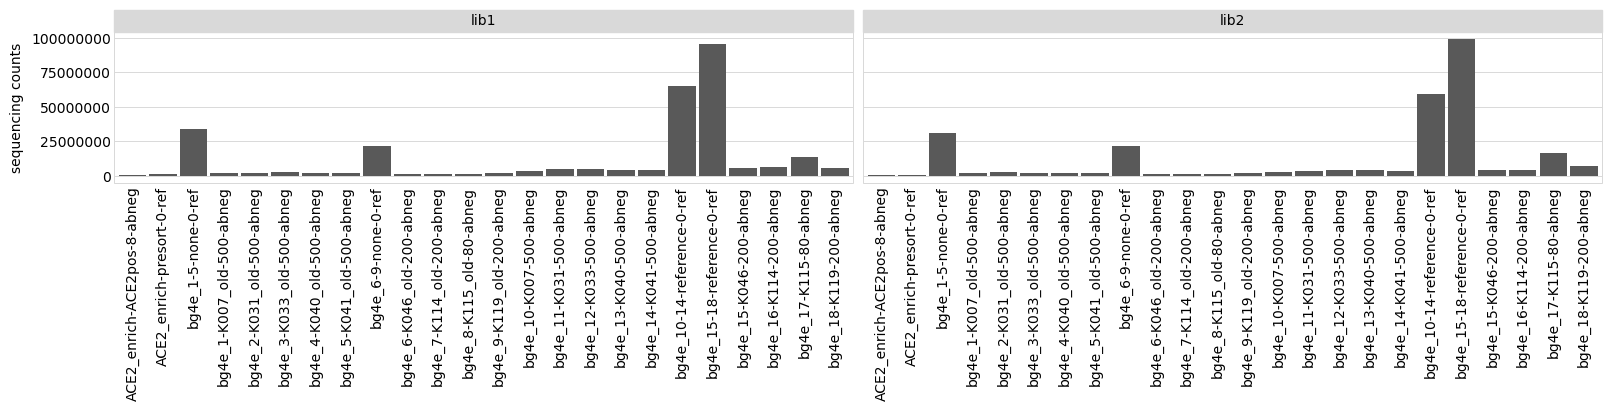

In [9]:
p = (
    ggplot((variants.variant_count_df
            .groupby(['library', 'sample'])
            .aggregate({'count': 'sum'})
            .reset_index()
           ),
           aes('sample','count')) +
    geom_bar(stat='identity') +
    facet_wrap('~library')+
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.4 * variants.variant_count_df['sample'].nunique() * variants.variant_count_df['library'].nunique(), 2),
          panel_grid_major_x=element_blank()) +
    xlab('')+
    ylab('sequencing counts')
    )

_ = p.draw()

Also curious to see how many unique barcodes there are per sample. 

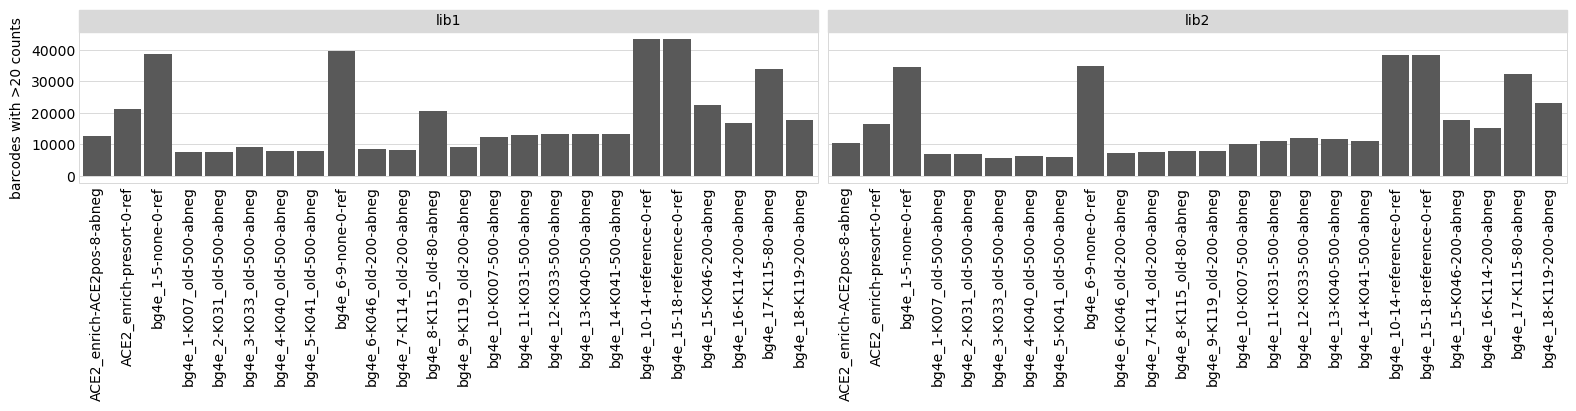

In [10]:
p = (
    ggplot((variants.variant_count_df
            .query('count>20')
            [['library', 'sample', 'barcode']]
            .drop_duplicates()
            .reset_index()
           ),
           aes('sample')) +
    geom_bar() + 
    facet_wrap('~library')+
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.4 * variants.variant_count_df['sample'].nunique() * variants.variant_count_df['library'].nunique(), 2),
          panel_grid_major_x=element_blank()) +
    xlab('') +
    ylab('barcodes with >20 counts')
    )

_ = p.draw()

Analyze the variant counts per cell for each sample:

In [11]:
counts = (
    variants.variant_count_df
    .groupby(['library', 'sample'])
    .aggregate({'count': 'sum'})
    .merge(sample_info, on=['library', 'sample'], validate='one_to_one')
    .merge(variants.n_variants_df(samples=None)
                   .groupby('library')
                   .aggregate(n_variants=pd.NamedAgg('count', 'sum')),
           on='library', validate='many_to_one')
    .assign(counts_per_cell=lambda x: x['count'] / x['number_cells'])
    .drop(columns=['R1', 'date'])
    )

counts.head()

,library,sample,count,experiment,antibody,concentration,sort_bin,experiment_type,number_cells,frac_escape,n_variants,counts_per_cell
0,lib1,ACE2_enrich-ACE2pos-8-abneg,769161,ACE2_enrich,ACE2pos,8,abneg,ab_selection,31118467.0,0.900,44115,0.024717
1,lib1,ACE2_enrich-presort-0-ref,1235707,ACE2_enrich,presort,0,ref,ab_selection,NaN,NaN,44115,NaN
2,lib1,bg4e_1-5-none-0-ref,33976656,bg4e_1-5,none,0,ref,ab_selection,NaN,NaN,44115,NaN
3,lib1,bg4e_1-K007_old-500-abneg,2169579,bg4e_1,K007_old,500,abneg,ab_selection,527450.0,0.051,44115,4.113336
4,lib1,bg4e_2-K031_old-500-abneg,2079352,bg4e_2,K031_old,500,abneg,ab_selection,524121.0,0.044,44115,3.967313


For the each experiment type, plot the average counts per variant, the average cells per variant, and the average counts per cell for each library / sample:

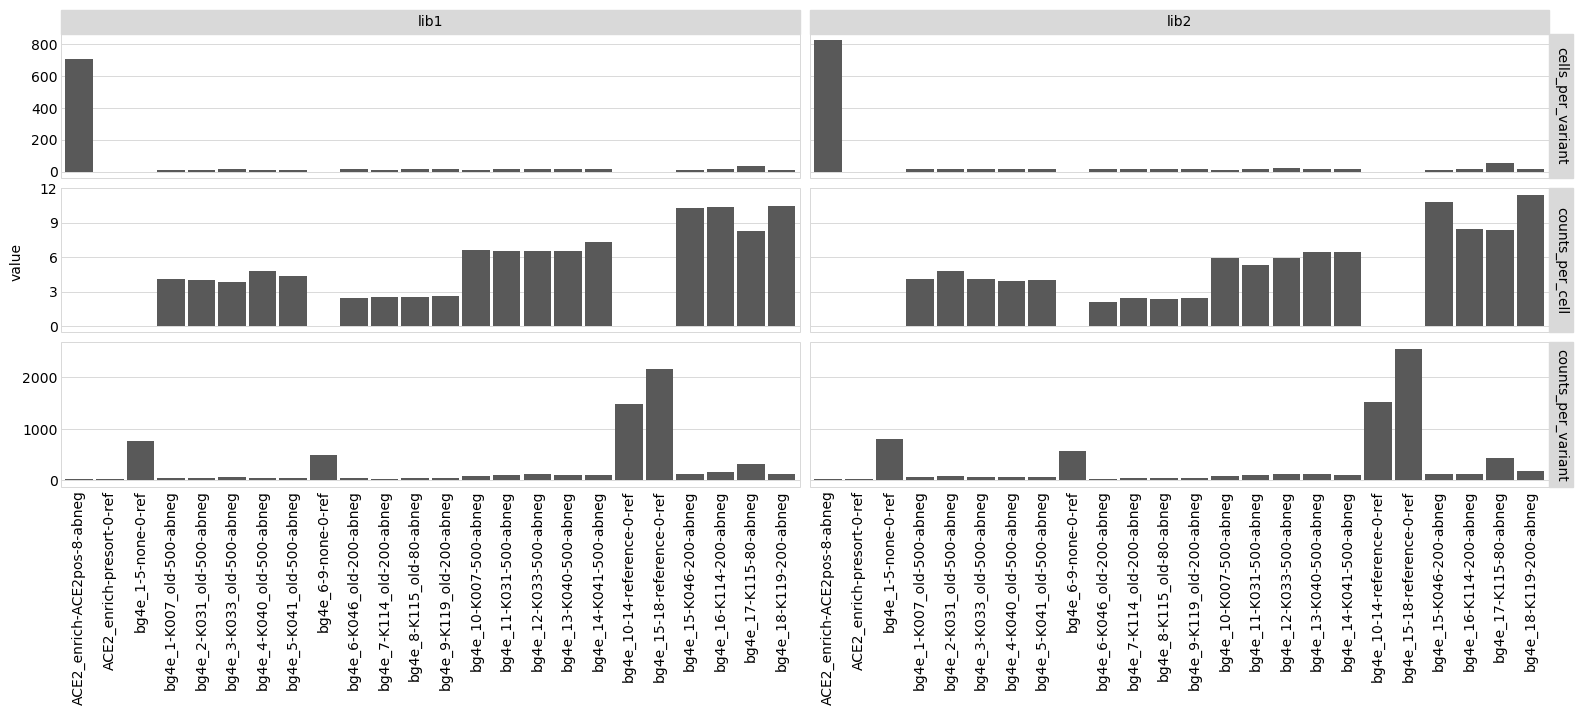

In [12]:

p = (
    ggplot(counts
                 .assign(counts_per_variant=lambda x: x['count'] / x['n_variants'],
                         cells_per_variant=lambda x: x['number_cells'] / x['n_variants'])
                 .melt(id_vars=['library', 'sample'],
                       value_vars=['counts_per_variant', 'cells_per_variant', 'counts_per_cell'],
                       var_name='statistic'),
           aes('sample', 'value')) +
    geom_bar(stat='identity') +
    facet_grid('statistic ~ library', scales='free_y') +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.4 * counts['sample'].nunique() * counts['library'].nunique(), 6),
          panel_grid_major_x=element_blank()) +
    xlab('')
    )

_ = p.draw()

## Mutations per variant
Average number of mutations per gene among all variants. To make the plot not too big, chunk the plots out for smaller subsets:

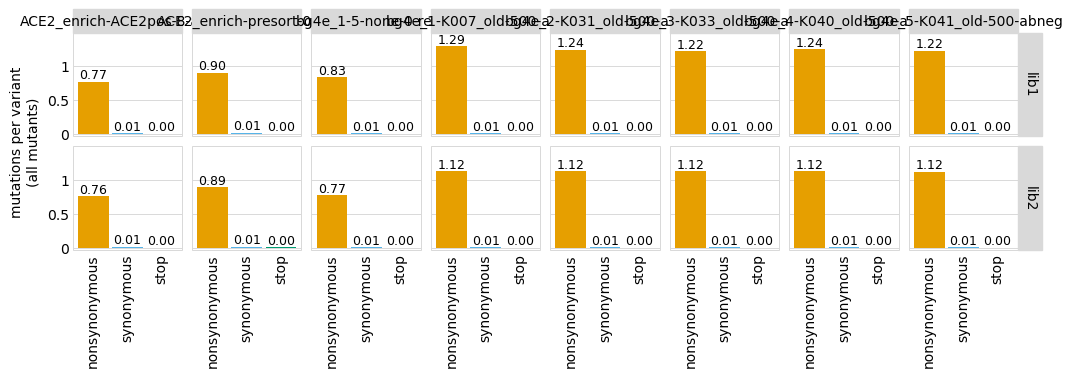

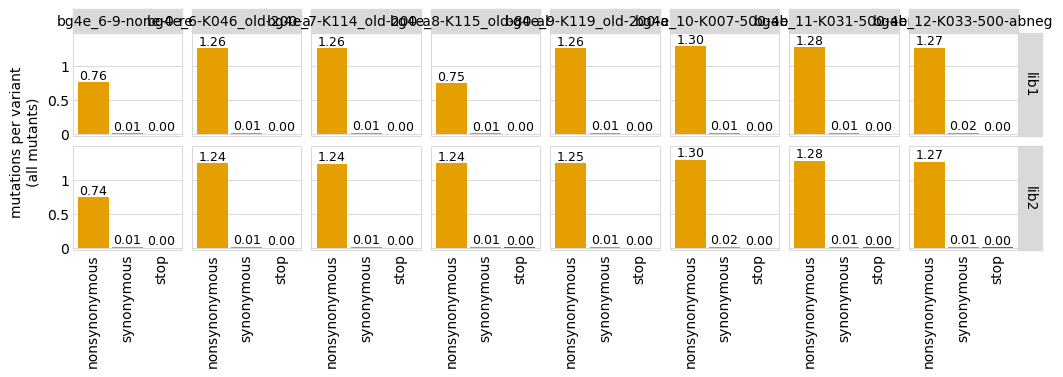

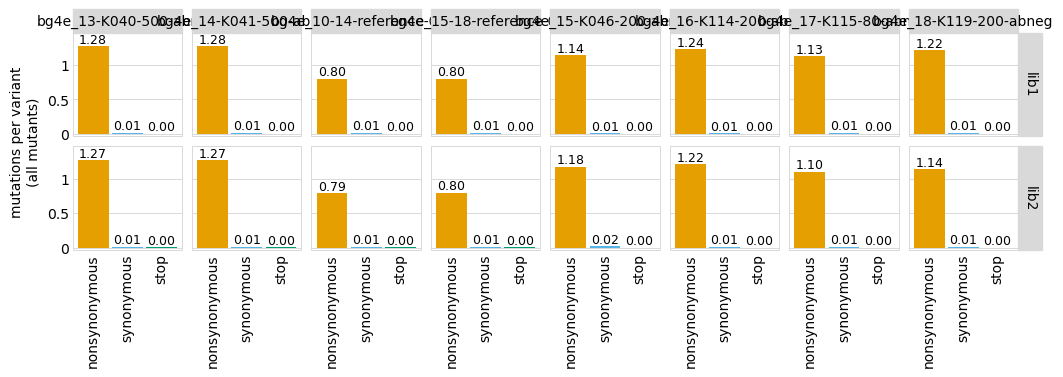

In [13]:
i = 0
chunksize = 8

while i < counts['sample'].nunique(): 
    p = variants.plotNumCodonMutsByType(variant_type='all',
                                        orientation='v',
                                        libraries=variants.libraries,
                                        samples=counts['sample'].unique().tolist()[i: i + chunksize],
                                        heightscale=0.8)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()

    i += chunksize

Mutation frequency across gene among all variants:

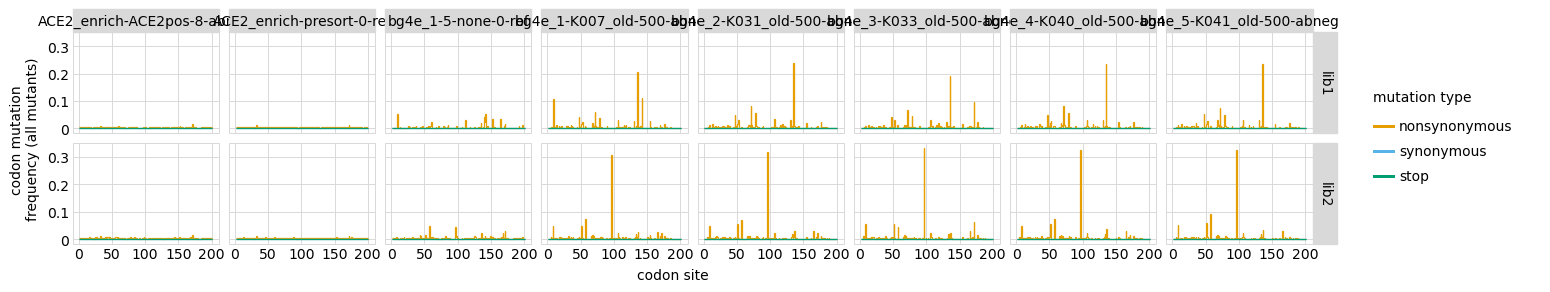

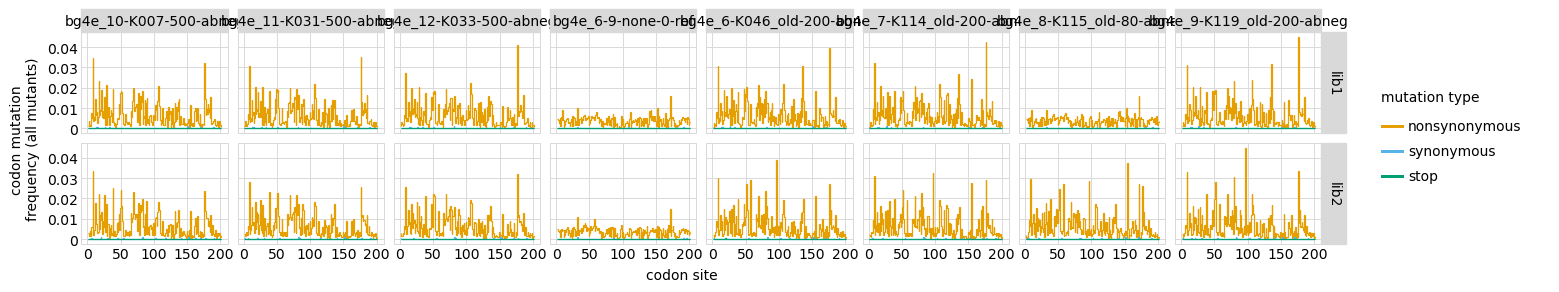

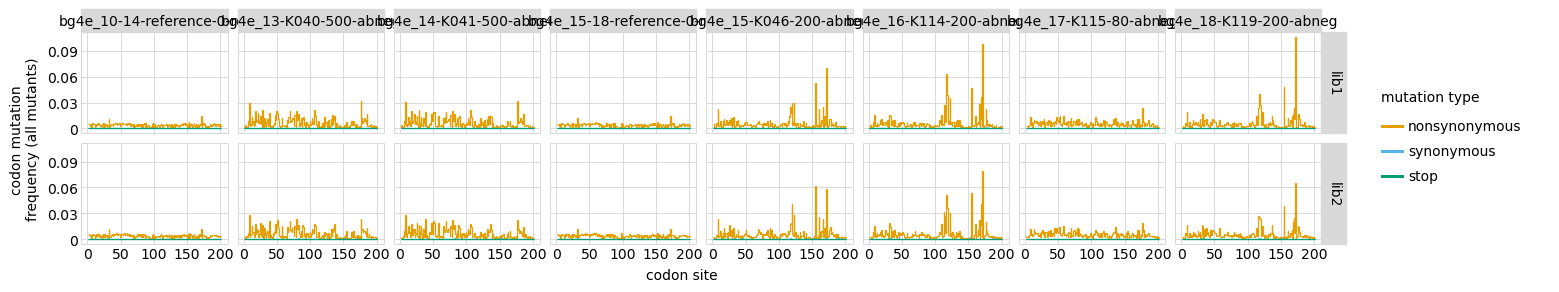

In [14]:
i = 0
chunksize = 8

while i < counts['sample'].nunique():    
    p = variants.plotMutFreqs('all',
                              'codon',
                              orientation='v',
                              libraries=variants.libraries,
                              samples=counts['sample'].unique().tolist()[i: i + chunksize],
                             )
    _ = p.draw()
    i += chunksize

Now plot the average mutation frequency for all samples:

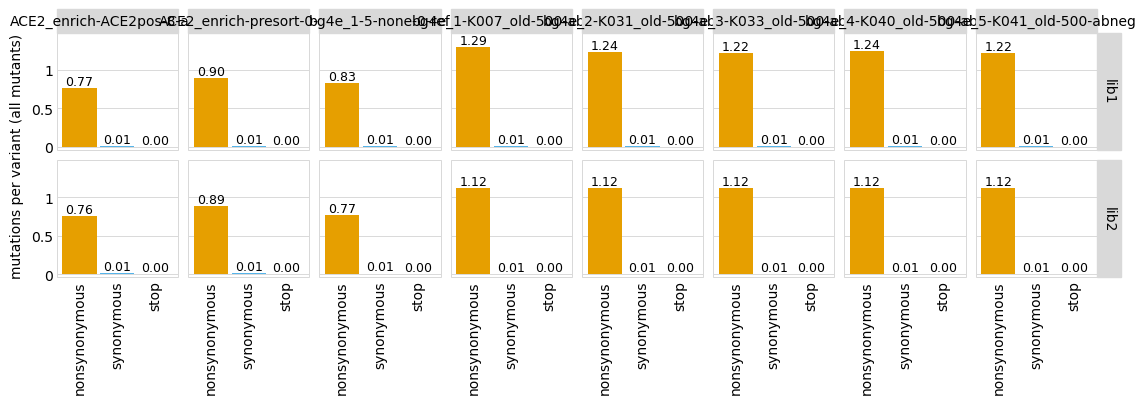

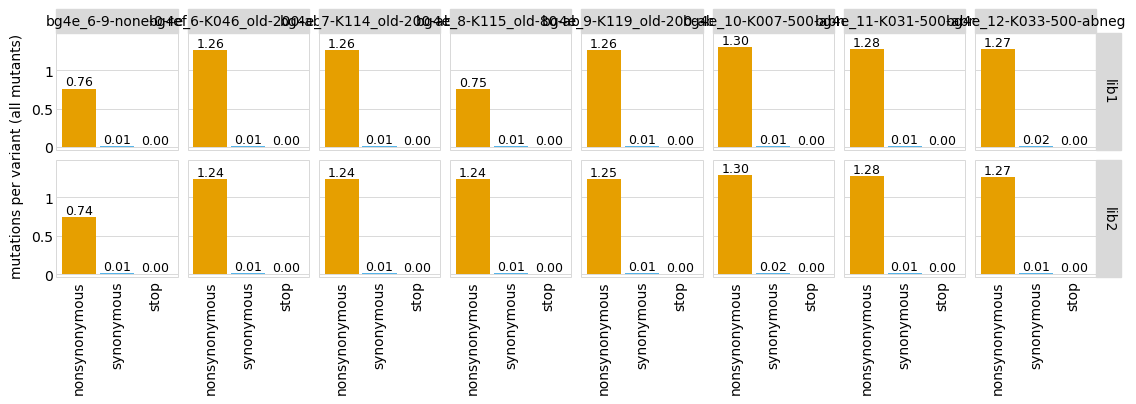

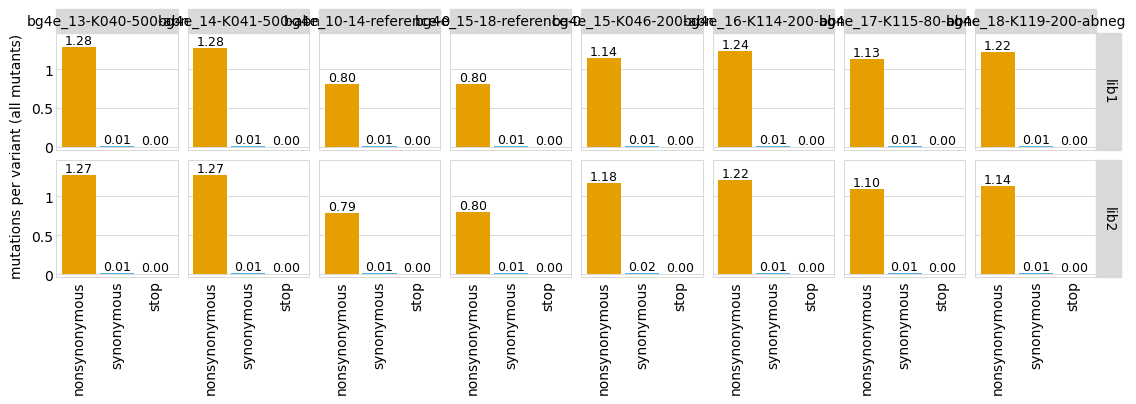

In [15]:
i = 0
chunksize = 8

while i < counts['sample'].nunique():
    p = variants.plotNumCodonMutsByType(
                                    variant_type='all',
                                    orientation='v',
                                    libraries=variants.libraries,
                                    samples=counts['sample'].unique().tolist()[i: i + chunksize],
                                    heightscale=0.9,
                                    widthscale=1.1)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()
    i += chunksize